<a href="https://colab.research.google.com/github/vksyr/IST718/blob/master/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kdnuggets.com/2018/09/end-to-end-project-time-series-analysis-forecasting-python.html

In [2]:
import pandas as pd  # data frame operations
import numpy as np  # arrays and math functions
from scipy.stats import uniform  # for training-and-test split
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
import matplotlib.pyplot as plt  # 2D plotting
import seaborn as sns  # PROVIDES TRELLIS AND SMALL MULTIPLE PLOTTING
import math

from pandas import Series
from statistics import mean
from statistics import median

from matplotlib import pyplot
import matplotlib.dates as mdates


from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import plotly as py
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.tsa.stattools as st
from scipy import stats as stats

!pip install pmdarima
import pmdarima as pm
from pmdarima.arima import auto_arima

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
np.set_printoptions(threshold=9999)

import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 1.5MB 2.8MB/s 


ARIMA functions

In [0]:
# define a function to run auto arima and search for best model parameters
def find_orders(ts, exog=None):

    stepwise_model = pm.auto_arima(ts, start_p=1, start_q=1, max_p=4, max_q=14,
                                exogenous=exog, 
                                m=12, seasonal=True, stationary=False,
                                stepwise=True, trend='ct',
                                suppress_warnings=True, trace=False, 
                                error_action='ignore')

    return stepwise_model.order, stepwise_model.seasonal_order

def fit_sarimax_model(ts, exog=None, order=(1,1,1), seasonal_order=(0, 0, 0, 12), summary=True, plot=True):
  
    # fit model with exog
    model = sm.tsa.statespace.SARIMAX(ts, 
                                  exog = exog,  
                                  order=order,
                                  seasonal_order=seasonal_order,
                                  trend='ct',
                                  enforce_stationarity=True,
                                  enforce_invertibility=False)

    output = model.fit(d=0)
    
    if summary==True:
        print(output.summary())

    if plot==True:
        # plot model diagnostics
        output.plot_diagnostics(figsize=(15, 18))
        plt.show()
        
    return output

def get_predictions(test, exog, model_output, plot=True, show=True):
    
    # Use the model to forecast twelve months into 2018 and store the confidence intervals
    pred = model_output.get_prediction(start=pd.to_datetime('2019-01-31'), end=pd.to_datetime('2019-12-31'), dynamic=False, exog=exog)
    pred_ci = pred.conf_int()
    
    # Plot the actual results for 2018 vs the projected results. 
    ax = test['2019-01-31':].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(8,6))
    
    
    if plot:
        #Plot observed and predicted values with confidence interval
        ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

        ax.set_xlabel('Date')
        ax.set_ylabel('Household Value')
        plt.legend(loc='upper left')
        plt.show()

    
    if show:
        
        # Obtain the predicted mean, merge with the actual values, and compute the MSE. 
        y_pred = pred.predicted_mean.reset_index()
        y_pred.columns = ['date', 'value']
        
        y_test = test.reset_index()
        
        # Compute the mean square error / RMSE
        mse = mean_squared_error(y_test.value, y_pred.value)

        rmse = math.sqrt(mse)
        r2 = r2_score(y_test.value, y_pred.value)

        # Print the results. 
        print('RMSE: ' +  str(format(round(rmse, 3))))
        print('R-squared: ' + str(format(round(r2, 3))))

def get_future(ds, exog, steps, model_output, plot):

    # Get forecast and confidence interval from base model, by steps 60
    

    #future_1y= model_output.forecast(steps=12, exog=exog)
    future_1y = model_output.get_forecast(steps=steps, exog=exog, dynamic=True)
    future_conf_1y = future_1y.conf_int(steps=steps)

    print(future_1y.predicted_mean)

    if plot: # plot results

        # 1 yr
        ax = ds.plot(label='Observed', figsize=(12, 8))
        future_1y.predicted_mean.plot(ax=ax, label='Forecast')
        ax.fill_between(future_conf_1y.index,
                        future_conf_1y.iloc[:, 0],
                        future_conf_1y.iloc[:, 1], color='k', alpha=.25)
        ax.xaxis.set_minor_locator(mdates.DayLocator())
        ax.set_xlabel('Date')
        ax.set_ylabel('Returns')
        ax.set_title('1-Year Forecast')
        ax.legend()
        plt.show()        

    df_out = future_conf_1y
    df_out['yhat'] = future_1y.predicted_mean
    df_out.columns = ['yhat_lower', 'yhat_upper', 'yhat']


    gain_df = pd.DataFrame({'value':df_out['yhat'].values, 'date':df_out.index})
    lastObs = pd.DataFrame({'value':ds.iloc[-1]['value'], 'date':ds.index[-1]}, index=[0])

    # preappend one row from actuals to forecast so that roi can be projected.
    gain_df = pd.concat([ lastObs, gain_df])
    gain_df = gain_df.set_index('date')

    roi = calculate_gain(gain_df, steps=steps, plot=False)

    print(str(steps) + '-Step ROI: ' + str(roi.iloc[0,0]))
    return (df_out)

# function to calculate gain percentage (ROI) on previous 2, 5 and 10 years
# source: https://github.com/gioamorim80/Zillow-Time-Series/blob/master/Module%204%20Final%20Project.ipynb
def calculate_gain(ts, steps=12, plot=True): 
    
    '''Takes a time series and performs calculations on returns over investments
    for period of 1 year'''
    
    # calculates ROI by taking current value, decreasing investment(value at x steps in past) and 
    # dividing by investment. Multiplies by 100 to get percentage number
    roi_1 = (ts - ts.shift(periods=steps))/ts.shift(periods=steps)*100
    roi_1.dropna(inplace=True)  

    # plot results
    if plot:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=roi_1.index, y=roi_1.value, name='1-Year Investment',
                                 line_color='deepskyblue'))
        
        fig.update_layout(title_text='ROI',
                          yaxis_title="ROI (%)", 
                          xaxis_rangeslider_visible=False)
        fig.show()
    
    # saves new ts with returns for 1 period
    return roi_1

COVID-19

In [0]:
baseUrl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
covid = pd.read_csv(baseUrl + 'time_series_19-covid-Confirmed.csv')

In [0]:
covid_us = covid.loc[covid['Country/Region']=='US']
covid_fl = covid_us[covid['Province/State']=='Florida']
covid_italy = covid.loc[covid['Country/Region']=='Italy']

def formatTS(ds):
  ds = ds.reset_index()
  ds.columns = ['date', 'value']
  ds['date'] = pd.to_datetime(ds['date'], format='%m/%d/%y', errors='coerce')
  ds['value'] = pd.to_numeric(ds['value'])
  ds = ds.set_index('date')
  return(ds)

covid_us = covid_us.transpose()
covid_us = covid_us.iloc[4:,:]
covid_us['total'] = covid_us.sum(axis=1)
covid_us = covid_us.iloc[:,len(covid_us.columns)-1]
covid_us = formatTS(covid_us)

covid_fl = covid_fl.transpose()
covid_fl = covid_fl.iloc[4:,:]
covid_fl = formatTS(covid_fl)

covid_italy = covid_italy.transpose()
covid_italy = covid_italy.iloc[4:,:]
covid_italy = formatTS(covid_italy)

2020-03-22     59130.129078
2020-03-23     66406.297921
2020-03-24     71641.063089
2020-03-25     82380.879596
2020-03-26     91728.731790
2020-03-27    101487.979247
2020-03-28    111216.356419
2020-03-29    121571.955850
2020-03-30    132950.791182
2020-03-31    145794.893441
2020-04-01    159661.289823
2020-04-02    174465.008368
Freq: D, dtype: float64


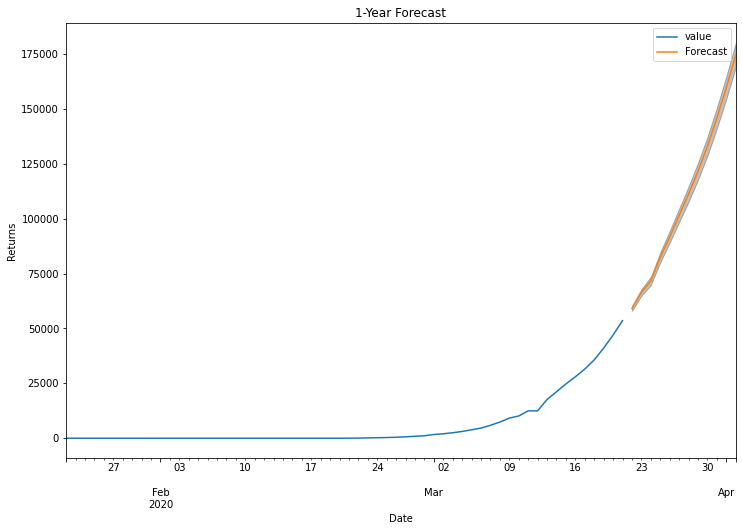

12-Step ROI: 225.6280719096118


In [78]:
# find best orders

def get_forecast(ds, steps):
  orders = find_orders(ds, exog=None) # takes a bit of time, best --> ((1, 1, 1), (1, 0, 1, 12))
  model_output = fit_sarimax_model(ds, None, order=orders[0], seasonal_order=orders[1], summary=False, plot=False)  
  get_future(ds, exog=None, steps=steps, model_output=model_output, plot=True)


get_forecast(covid_italy, 12)